In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
# import sklearn as sl
# from sklearn.neighbors import LocalOutlierFactor

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
# plt.style.use('default')
font1 ={'family': 'times', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    j= 0
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(11):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=3, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')

    plt.show()
    return 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


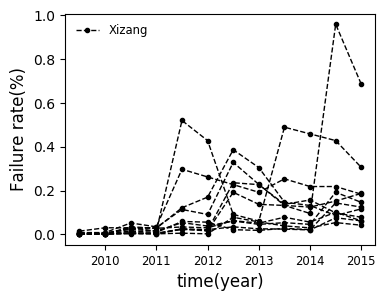

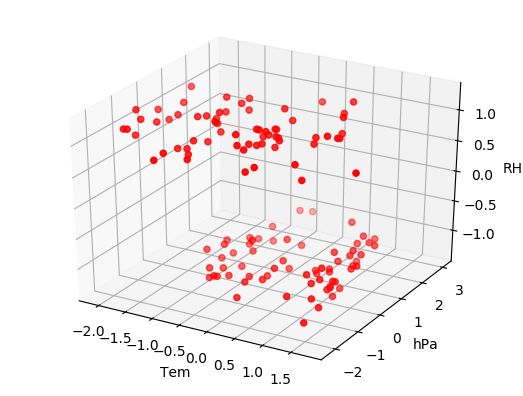

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12_longB.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中




# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 0.5, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)

elec_data.Fault.values[118] =210
elec_data.Fault.values[119] =150
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(11)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(11)])

# 画图
Plot_XZ(elec_year2, elec_faults2)

# plt.figure(figsize=(4, 3), facecolor='w')
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_tem1, elec_hPa1, elec_RH1, c='r')
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

In [4]:
from lof import *
# Instane2：为故障+时间
# Instane3：为温度+压强+湿度
# Instane4：为故障+时间+温度+压强
# Instane5：为故障+时间+温度+压强+湿度

Instane2 =[
[ -0.6960818063139069 , -1.5932550136313832 ] ,
[ -0.6960818063139069 , -1.3035722838802226 ] ,
[ -0.4623108127945375 , -1.013889554129062 ] ,
[ -0.5114223660549093 , -0.7242068243779014 ] ,
[ -0.46820419918578204 , -0.43452409462674085 ] ,
[ -0.4957066690115903 , -0.14484136487558028 ] ,
[ -0.26782906188346534 , 0.14484136487558028 ] ,
[ -0.348372009230475 , 0.43452409462674085 ] ,
[ -0.1597836447106476 , 0.7242068243779014 ] ,
[ -0.3149761530134223 , 1.013889554129062 ] ,
[ -0.0006622121470431206 , 1.3035722838802226 ] ,
[ -0.2756869104051249 , 1.5932550136313832 ] ,
[ -0.698858413068419 , -1.5932550136313832 ] ,
[ -0.698858413068419 , -1.3035722838802226 ] ,
[ -0.6628177489565101 , -1.013889554129062 ] ,
[ -0.6718279149844872 , -0.7242068243779014 ] ,
[ -0.5276652585368518 , -0.43452409462674085 ] ,
[ -0.5546957566207835 , -0.14484136487558028 ] ,
[ -0.4645940963410113 , 0.14484136487558028 ] ,
[ -0.5276652585368518 , 0.43452409462674085 ] ,
[ -0.5366754245648291 , 0.7242068243779014 ] ,
[ -0.5637059226487607 , 1.013889554129062 ] ,
[ -0.17626878344574035 , 1.3035722838802226 ] ,
[ -0.27538060975348966 , 1.5932550136313832 ] ,
[ -0.6861083642793375 , -1.5932550136313832 ] ,
[ -0.6861083642793375 , -1.3035722838802226 ] ,
[ -0.599067505011103 , -1.013889554129062 ] ,
[ -0.6425879346452202 , -0.7242068243779014 ] ,
[ -0.294424497572282 , -0.43452409462674085 ] ,
[ -0.3161847123893406 , -0.14484136487558028 ] ,
[ -0.5555470753769857 , 0.14484136487558028 ] ,
[ -0.5773072901940444 , 0.43452409462674085 ] ,
[ -0.5120266457428684 , 0.7242068243779014 ] ,
[ -0.5555470753769857 , 1.013889554129062 ] ,
[ 0.2931013024883013 , 1.3035722838802226 ] ,
[ 0.16254001358594958 , 1.5932550136313832 ] ,
[ -0.6469540803928013 , -1.5932550136313832 ] ,
[ -0.6469540803928013 , -1.3035722838802226 ] ,
[ -0.3423815868748274 , -1.013889554129062 ] ,
[ -0.46421058428201695 , -0.7242068243779014 ] ,
[ 1.3632243768258268 , -0.43452409462674085 ] ,
[ 1.1195663820114479 , -0.14484136487558028 ] ,
[ 0.8759083871970685 , 0.14484136487558028 ] ,
[ 0.6322503923826894 , 0.43452409462674085 ] ,
[ 1.0586518833078529 , 0.7242068243779014 ] ,
[ 0.8149938884934739 , 1.013889554129062 ] ,
[ 0.8149938884934739 , 1.3035722838802226 ] ,
[ 0.5713358936790948 , 1.5932550136313832 ] ,
[ -0.6542266119363125 , -1.5932550136313832 ] ,
[ -0.6542266119363125 , -1.3035722838802226 ] ,
[ -0.5469426776161451 , -1.013889554129062 ] ,
[ -0.6005846447762287 , -0.7242068243779014 ] ,
[ -0.3323748089758102 , -0.43452409462674085 ] ,
[ -0.43965874329597765 , -0.14484136487558028 ] ,
[ -0.27873284181572644 , 0.14484136487558028 ] ,
[ -0.3860167761358939 , 0.43452409462674085 ] ,
[ -0.3323748089758102 , 0.7242068243779014 ] ,
[ -0.3860167761358939 , 1.013889554129062 ] ,
[ 0.6331805999056965 , 1.3035722838802226 ] ,
[ 0.3113287969451945 , 1.5932550136313832 ] ,
[ -0.6014057371864551 , -1.5932550136313832 ] ,
[ -0.49494289527651397 , -1.3035722838802226 ] ,
[ -0.49494289527651397 , -1.013889554129062 ] ,
[ -0.6014057371864551 , -0.7242068243779014 ] ,
[ 2.911868045841602 , -0.43452409462674085 ] ,
[ 2.2730909943819557 , -0.14484136487558028 ] ,
[ -0.06909152763674935 , 0.14484136487558028 ] ,
[ -0.28201721145663167 , 0.43452409462674085 ] ,
[ 2.6989423620217203 , 0.7242068243779014 ] ,
[ 2.486016678201838 , 1.013889554129062 ] ,
[ 2.2730909943819557 , 1.3035722838802226 ] ,
[ 1.4213882591024263 , 1.5932550136313832 ] ,
[ -0.6868513927972499 , -1.5932550136313832 ] ,
[ -0.6868513927972499 , -1.3035722838802226 ] ,
[ -0.6868513927972499 , -1.013889554129062 ] ,
[ -0.6868513927972499 , -0.7242068243779014 ] ,
[ -0.6658342064981038 , -0.43452409462674085 ] ,
[ -0.6868513927972499 , -0.14484136487558028 ] ,
[ -0.16142173531859474 , 0.14484136487558028 ] ,
[ -0.30854203941261826 , 0.43452409462674085 ] ,
[ -0.43464515720749547 , 0.7242068243779014 ] ,
[ -0.4976967161049341 , 1.013889554129062 ] ,
[ -0.3295592257117645 , 1.3035722838802226 ] ,
[ -0.4136279709083493 , 1.5932550136313832 ] ,
[ -0.6991670522019792 , -1.5932550136313832 ] ,
[ -0.6991670522019792 , -1.3035722838802226 ] ,
[ -0.6643609446243112 , -1.013889554129062 ] ,
[ -0.6904655253075622 , -0.7242068243779014 ] ,
[ -0.5338380412080562 , -0.43452409462674085 ] ,
[ -0.5947487294689752 , -0.14484136487558028 ] ,
[ 0.6321665626438221 , 0.14484136487558028 ] ,
[ 0.24929937928947413 , 0.43452409462674085 ] ,
[ 0.21449327171180613 , 0.7242068243779014 ] ,
[ 0.16228411034530396 , 1.013889554129062 ] ,
[ 0.35371770202247804 , 1.3035722838802226 ] ,
[ 0.5973604550661541 , 1.5932550136313832 ] ,
[ -0.6724568512720672 , -1.5932550136313832 ] ,
[ -0.6901631659100905 , -1.3035722838802226 ] ,
[ -0.49540902929566955 , -1.013889554129062 ] ,
[ -0.5131189492586948 , -0.7242068243779014 ] ,
[ 0.14192635593101768 , -0.43452409462674085 ] ,
[ 0.47827332522926475 , -0.14484136487558028 ] ,
[ 1.983011725883295 , 0.14484136487558028 ] ,
[ 1.4164565384611247 , 0.43452409462674085 ] ,
[ 0.3188624282709603 , 0.7242068243779014 ] ,
[ 0.2126254475834431 , 1.013889554129062 ] ,
[ -0.10602241777297297 , 1.3035722838802226 ] ,
[ 0.10637315162133193 , 1.5932550136313832 ] ,
[ -0.6760791122013075 , -1.5932550136313832 ] ,
[ -0.6760791122013075 , -1.3035722838802226 ] ,
[ -0.517131777725864 , -1.013889554129062 ] ,
[ -0.4853423108307754 , -0.7242068243779014 ] ,
[ 0.086868093280821 , -0.43452409462674085 ] ,
[ -0.0720792411946224 , -0.14484136487558028 ] ,
[ 1.5809730373499893 , 0.14484136487558028 ] ,
[ 0.8816047656580382 , 0.43452409462674085 ] ,
[ 0.2140259608611759 , 0.7242068243779014 ] ,
[ -0.040289774299533704 , 1.013889554129062 ] ,
[ 5.967919468872228 , 1.3035722838802226 ] ,
[ 4.060551455166908 , 1.5932550136313832 ] ,
[ -0.6969149632374163 , -1.5932550136313832 ] ,
[ -0.6859613473784365 , -1.3035722838802226 ] ,
[ -0.6531004998014968 , -1.013889554129062 ] ,
[ -0.6750077315194566 , -0.7242068243779014 ] ,
[ -0.543564341211698 , -0.43452409462674085 ] ,
[ -0.5764251887886376 , -0.14484136487558028 ] ,
[ 0.9351737997505859 , 0.14484136487558028 ] ,
[ 0.8749289125261964 , 0.43452409462674085 ] ,
[ 0.2505728085643434 , 0.7242068243779014 ] ,
[ 0.38749300680159166 , 1.013889554129062 ] ,
[ -0.02326758791015369 , 1.3035722838802226 ] ,
[ -0.16018778614740228 , 1.5932550136313832 ]
]





Instane3= [
[ 0.7865959950092807 , 0.9631246479276664 , 0.8908869506724078 ] ,
[ 1.2812675294001359 , 0.6700769357274918 , -0.967703258428422 ] ,
[ -0.8781489508080291 , -0.23294810866148985 , 1.1642498930720782 ] ,
[ 1.1784188292883377 , -0.17882481378576887 , -1.085551293641741 ] ,
[ -1.7869777989532856 , -0.7147660378244122 , 0.9105957610868853 ] ,
[ -0.27905804400885237 , 0.10697249286457924 , -1.1015011456093928 ] ,
[ -0.07918893295049934 , -0.9988591307472816 , 0.8996186466969746 ] ,
[ 1.429534050545247 , 0.9011678742293693 , -0.7955137636127583 ] ,
[ 0.039369602932623315 , 0.3054006595758503 , 0.8595336412017468 ] ,
[ -0.6459767977360413 , -0.8628507028191534 , -0.8466889523279829 ] ,
[ -1.1631829254853456 , 2.496533928260311 , 1.0271532931118532 ] ,
[ 0.16464594600043403 , 0.0741604920301661 , -0.9995394224109982 ] ,
[ 0.9058656529888272 , -1.0146799659597479 , 0.9210867580647383 ] ,
[ 1.246617673841572 , 1.0109751588167162 , -0.8638462683111886 ] ,
[ -0.9929146056969786 , 1.0311028909411695 , 1.0208085091677956 ] ,
[ 1.0130449500042682 , -0.11832563840175937 , -0.909081292545341 ] ,
[ -1.8623275613764187 , 0.08452301522902973 , 0.89820390074586 ] ,
[ -0.435208368707528 , -0.13570006781919977 , -0.9143518531265915 ] ,
[ -0.10961158863711198 , -0.8038575144406085 , 0.8469204531635611 ] ,
[ 1.4112207368856968 , 1.9192280692591082 , -1.3295833712502103 ] ,
[ -0.1224493079255702 , 1.9312461660277067 , 0.8017285625001612 ] ,
[ -0.5998373179344832 , 0.06521264774102435 , -0.9075319845920017 ] ,
[ -0.9963830002741235 , 0.21989235307860605 , 1.0460819726025141 ] ,
[ -0.0019106319749986641 , 1.5291078012274364 , -0.9941698280241771 ] ,
[ 0.7297728942179195 , -0.5833633641435918 , 1.1374711541662335 ] ,
[ 1.2826580152819853 , 1.0015202752896981 , -1.0688525206091777 ] ,
[ -0.821048974591641 , 0.4349777919219117 , 0.7338357392985269 ] ,
[ 0.9600343507268532 , -0.7076546727138283 , -1.0882244421426683 ] ,
[ -1.9797728551236402 , -0.19253404519851117 , 1.0681476883466985 ] ,
[ -0.5133346613715647 , 0.14350702543129554 , -1.1625772578474602 ] ,
[ -0.018606510713688552 , -0.4023776491652155 , 1.232573747034981 ] ,
[ 1.5342978428292462 , 1.2568997531812505 , -1.22180718779387 ] ,
[ -0.041250798513859044 , 1.2684540406047853 , 0.9907761973487337 ] ,
[ -0.5068134250719637 , -0.4135102624234343 , -0.9200879258211984 ] ,
[ -1.0060389453453797 , -2.5965039118093274 , 1.0305434895673002 ] ,
[ 0.148874253073486 , -0.6509728799813275 , -1.0301576642211214 ] ,
[ 0.8249442869857004 , -0.3256245163287158 , 1.0682881678094807 ] ,
[ 1.2506147557870826 , 0.13222938038879983 , -1.096428017421947 ] ,
[ -0.7456561857176941 , -1.5368776811623592 , 0.8604127902110663 ] ,
[ 0.8963193115324035 , 0.18094328204888405 , -1.2713957749227571 ] ,
[ -2.065644194902929 , -0.12497164955063599 , 0.983113945500006 ] ,
[ -0.43439641204676316 , -0.3192444380622004 , -0.9715427447978422 ] ,
[ -0.08428617428051335 , -0.7040184014687474 , 1.3629695626981344 ] ,
[ 1.3820853136782487 , -0.41862781041041697 , -1.1838352645859456 ] ,
[ 0.03546098781372027 , 0.4837748304395474 , 0.7669391877355544 ] ,
[ -0.7405831266664009 , 1.626468054170271 , -0.9061278581506191 ] ,
[ -1.0208647161910862 , 0.44653105032899276 , 1.07646595949394 ] ,
[ 0.18615716906360613 , -0.5186386293637071 , -0.7869451303764343 ] ,
[ 0.6284600360103063 , -1.3319532174755904 , 0.905060078521735 ] ,
[ 1.1415530242642717 , 1.212774311904543 , -1.0263650880059683 ] ,
[ -0.7865953678320368 , -0.2474021819126354 , 0.9976819840897787 ] ,
[ 0.9620215652807843 , 0.4625187371818503 , -0.6271020483289579 ] ,
[ -2.0230266662615457 , -0.3644561915351632 , 1.1635855557094907 ] ,
[ -0.6632830901851028 , -1.110951098514941 , -0.9545373018397126 ] ,
[ 0.07182821027113297 , -0.07572570173670033 , 0.9894896854816984 ] ,
[ 1.3114203153752755 , -1.3972107730513883 , -1.1106610507951293 ] ,
[ 0.14066698016048224 , -0.3510048426781113 , 0.9662360845029073 ] ,
[ -0.767097043332268 , -0.1648038347201096 , -1.0751257880106981 ] ,
[ -1.093611251083244 , 1.0756930963467692 , 1.0664662675510084 ] ,
[ 0.43435063665101115 , 1.2320965765824414 , -0.882819410958605 ] ,
[ 0.7901064542298025 , 0.5304142503109696 , 1.1582813687440499 ] ,
[ 1.216076899779907 , 0.1277452069263907 , -1.1790267142221782 ] ,
[ -0.7733356509124005 , 0.17218726868379378 , 0.98662931729236 ] ,
[ 0.888545050304473 , 1.015441052017047 , -1.2072879221279496 ] ,
[ -1.8723856873343383 , 0.37827376944435864 , 0.9681004021914923 ] ,
[ -0.4674631706875075 , 0.11603441479119986 , -1.0364300933530715 ] ,
[ -0.031327969464587754 , -0.45818439683742274 , 1.1277709797398852 ] ,
[ 1.4299513922756124 , -0.8057934318557146 , -0.9460494413486976 ] ,
[ 0.04423457421581129 , -1.033707387142741 , 0.8400265892499876 ] ,
[ -0.7104651795016453 , 1.424182364479934 , -0.6642333629453567 ] ,
[ -0.9229739541183702 , -1.19626703089728 , 0.9326270092377112 ] ,
[ 0.21665981309817234 , 1.0801426267148246 , -1.128389303507681 ] ,
[ 0.6863029604956011 , -0.2068251717699579 , 0.8076924902783492 ] ,
[ 1.2401819273014485 , 0.6391220239311678 , -1.0980435137620022 ] ,
[ -0.7377890541758104 , -0.8215898893601199 , 0.9211423410537418 ] ,
[ 0.9692817796728955 , 1.6112452735526106 , -0.8609361314321566 ] ,
[ -1.9305194022239556 , 0.3723241737013173 , 1.14016494373458 ] ,
[ -0.4008276218009715 , -1.186877957418215 , -0.8257927818782376 ] ,
[ -0.14831479827478916 , -0.13057296600962776 , 1.0165070707720474 ] ,
[ 1.510976629549663 , -0.6983994530604585 , -1.0411473565823006 ] ,
[ 0.04871251076872057 , -0.5434712564244445 , 1.0665418282069472 ] ,
[ -0.6443932146680031 , -1.0585809106389943 , -0.9640040431738388 ] ,
[ -0.9483765941519757 , 1.291638157767576 , 1.1195094073772338 ] ,
[ 0.15287587346532244 , -0.13252244263912388 , -0.9320705819183801 ] ,
[ 0.939465417955752 , -0.5852911961985229 , 1.1450651979743476 ] ,
[ 1.146161613921222 , 0.18702912239771252 , -0.7394207534025605 ] ,
[ -0.9259700130954757 , -0.7106886733365162 , 0.902940941064788 ] ,
[ 0.9542649768089885 , -0.25158346569015916 , -0.994438029246928 ] ,
[ -1.8520539323522316 , -1.0906690018440026 , 0.9546149646611535 ] ,
[ -0.5107835338595736 , -0.60995626004362 , -1.0190865102695972 ] ,
[ -0.22117629668533234 , 0.9696648671678485 , 0.914908182264726 ] ,
[ 1.486583808338243 , 0.4010417796272091 , -0.8593805477715908 ] ,
[ 0.04602802235156332 , -1.2841372926320909 , 0.9935528225773839 ] ,
[ -0.7890593024025523 , -0.8372746422809816 , -0.7398826396847353 ] ,
[ -1.1266218237007573 , -2.295904188633196 , 0.8183487231008553 ] ,
[ 0.21168502525407515 , 1.2145954456798647 , -0.6748589269659766 ] ,
[ 0.775452949121791 , 0.0306511057311373 , 1.0925444021936657 ] ,
[ 1.2185211398135156 , 0.10969212789653825 , -1.0971708674359968 ] ,
[ -0.8542466197214477 , -0.09278424079626689 , 0.9484655174694477 ] ,
[ 1.0260735794639093 , -0.9572794329170771 , -1.2493771743015651 ] ,
[ -1.9178168283488852 , -0.012227090332011303 , 0.9450428530554001 ] ,
[ -0.4842791822501501 , 0.6825118091514719 , -1.1667456406508212 ] ,
[ 0.06496660616858602 , 3.0717888427206383 , 0.8225668285096248 ] ,
[ 1.35217737318374 , 1.6932040276217808 , -1.116381559477808 ] ,
[ 0.0008685550379544722 , 0.9049862946287525 , 0.8610218198444817 ] ,
[ -0.6902201929573762 , -1.413874665857104 , -0.8674047162126514 ] ,
[ -0.9743433449981581 , 0.2469447133840212 , 0.9286323288317637 ] ,
[ 0.04294539380972225 , 0.9565444503506455 , -0.7511540713205218 ] ,
[ 0.770090218842866 , 0.6465254360438588 , 1.0838296257164644 ] ,
[ 1.2284229769499735 , -2.5772152171831997 , -1.1226511565408441 ] ,
[ -0.9382889755045994 , 0.8131788583810212 , 1.1065220348503073 ] ,
[ 0.7846592575340886 , -1.253064456754309 , -1.0892209049843073 ] ,
[ -1.991959267244784 , 0.2516169414760687 , 1.0344876456329475 ] ,
[ -0.3013250572104504 , 0.056859812971932926 , -1.033351746706218 ] ,
[ 0.020755978841893157 , -0.5896855927097482 , 1.23664380556119 ] ,
[ 1.5363925910144636 , 1.5778500809794924 , -1.0507571528849313 ] ,
[ -0.0916373328505064 , -0.9315910427819286 , 0.9505308999583292 ] ,
[ -0.7725193076124841 , 1.8851522524212283 , -0.7476155233249983 ] ,
[ 2.1604821079114966 , 1.286011157558871 , 1.0138692919062129 ] ,
[ 1.1775381061093024 , -0.029652978598223304 , -1.1593284565005368 ] ,
[ 0.7323694036307878 , -1.4122363029922818 , 0.9437996862639311 ] ,
[ 1.4358449260856883 , -2.6206269469644394 , -1.0615947029777162 ] ,
[ -1.0201355342817942 , -1.222832013761946 , 0.973628932131356 ] ,
[ 1.1599586417855035 , 0.2381880474305388 , -1.0873360904527005 ] ,
[ -1.957173400546376 , -0.41770650063762776 , 0.9873086581160063 ] ,
[ -0.28557963374929546 , -0.9681099832000151 , -0.8374359181816479 ] ,
[ 0.05088373505506321 , 0.14413555373842998 , 1.1788635564901697 ] ,
[ 1.4730285008568933 , 0.19904127603623833 , -0.9328991075504354 ] ,
[ -0.06982570296772946 , 0.6457859799019493 , 0.9041260702245378 ] ,
[ -0.65261953704556 , 0.11199566104248077 , -1.11120064580414 ] ,
[ -1.2470948290040735 , -0.9009346117844835 , 0.8338099726093664 ] ,
[ 0.16036049049982445 , -0.413501739574657 , -0.8552851366286994 ]
]






Instane4 =[
[ -0.6960818063139069 , -1.5932550136313832 , 0.6961711513747821 , 0.5795322193650706 ] ,
[ -0.6960818063139069 , -1.3035722838802226 , 1.473907534840755 , -0.44434962647142073 ] ,
[ -0.4623108127945375 , -1.013889554129062 , -0.9226290443793739 , 0.06417588974868281 ] ,
[ -0.5114223660549093 , -0.7242068243779014 , 1.162140604881822 , -0.715983122947199 ] ,
[ -0.46820419918578204 , -0.43452409462674085 , -1.7271694677377891 , -0.40041726093012353 ] ,
[ -0.4957066690115903 , -0.14484136487558028 , -0.36937439271508676 , -0.5693138284140599 ] ,
[ -0.26782906188346534 , 0.14484136487558028 , 0.023479999517994243 , 1.1512571764159243 ] ,
[ -0.348372009230475 , 0.43452409462674085 , 1.5111193555104263 , 1.061132414357567 ] ,
[ -0.1597836447106476 , 0.7242068243779014 , 0.028244486759369056 , -0.4880115323161076 ] ,
[ -0.3149761530134223 , 1.013889554129062 , -0.7074329351131353 , 1.5300757448828974 ] ,
[ -0.0006622121470431206 , 1.3035722838802226 , -1.0177307672824445 , -0.9747867814872424 ] ,
[ -0.2756869104051249 , 1.5932550136313832 , 0.16600494696325355 , -0.41056969342418964 ] ,
[ -0.698858413068419 , -1.5932550136313832 , 1.0038719801076494 , -0.6857362615852431 ] ,
[ -0.698858413068419 , -1.3035722838802226 , 1.3342362078093715 , 0.6305254958627402 ] ,
[ -0.6628177489565101 , -1.013889554129062 , -0.8576748358135772 , 1.0258161231859653 ] ,
[ -0.6718279149844872 , -0.7242068243779014 , 1.059745842483924 , -1.799211940504513 ] ,
[ -0.5276652585368518 , -0.43452409462674085 , -1.9601385475483724 , 0.041975290456312424 ] ,
[ -0.5546957566207835 , -0.14484136487558028 , -0.5559752183228004 , -0.060749265980411894 ] ,
[ -0.4645940963410113 , 0.14484136487558028 , -0.18373772560525498 , 0.688128694800448 ] ,
[ -0.5276652585368518 , 0.43452409462674085 , 1.5733974738779686 , -1.3638558586049208 ] ,
[ -0.5366754245648291 , 0.7242068243779014 , 0.08556963663346707 , 0.32118688192372813 ] ,
[ -0.5637059226487607 , 1.013889554129062 , -0.5627294189692421 , -2.8240981800555125 ] ,
[ -0.17626878344574035 , 1.3035722838802226 , -1.1109336055242236 , 0.7536288682184307 ] ,
[ -0.27538060975348966 , 1.5932550136313832 , 0.2423153241021874 , 1.326275655104373 ] ,
[ -0.6861083642793375 , -1.5932550136313832 , 0.8168847558374788 , 0.14767638144211398 ] ,
[ -0.6861083642793375 , -1.3035722838802226 , 1.2559766986723135 , -0.8484310882548849 ] ,
[ -0.599067505011103 , -1.013889554129062 , -0.9743306615263412 , 0.41670149715458993 ] ,
[ -0.6425879346452202 , -0.7242068243779014 , 1.1789415635676757 , 1.2848182272829702 ] ,
[ -0.294424497572282 , -0.43452409462674085 , -1.8604331791900695 , 1.256844230863481 ] ,
[ -0.3161847123893406 , -0.14484136487558028 , -0.5904693616303097 , -0.4801414412965155 ] ,
[ -0.5555470753769857 , 0.14484136487558028 , -0.1066621508768774 , 0.2289903663985218 ] ,
[ -0.5773072901940444 , 0.43452409462674085 , 1.5813999178077858 , -1.5151100138880669 ] ,
[ -0.5120266457428684 , 0.7242068243779014 , 0.04595669923149047 , 0.4364545614014288 ] ,
[ -0.5555470753769857 , 1.013889554129062 , -0.6659136576745852 , 0.3357282201734178 ] ,
[ 0.2931013024883013 , 1.3035722838802226 , -1.0882477101211725 , -0.11980741556759676 ] ,
[ 0.16254001358594958 , 1.5932550136313832 , 0.37576158694749445 , -0.65927434006788 ] ,
[ -0.6469540803928013 , -1.5932550136313832 , 0.8323137012527084 , -0.40869665928055265 ] ,
[ -0.6469540803928013 , -1.3035722838802226 , 1.1917859275816618 , -0.514841502310719 ] ,
[ -0.3423815868748274 , -1.013889554129062 , -0.7179848024745503 , -1.0856117994653334 ] ,
[ -0.46421058428201695 , -0.7242068243779014 , 0.583838555025355 , -0.2929232420188437 ] ,
[ 1.3632243768258268 , -0.43452409462674085 , -1.8464565792904282 , -1.703043883194195 ] ,
[ 1.1195663820114479 , -0.14484136487558028 , -0.4148492297140116 , 0.04482553757481111 ] ,
[ 0.8759083871970685 , 0.14484136487558028 , 0.26975477845147433 , -0.3523111811923747 ] ,
[ 0.6322503923826894 , 0.43452409462674085 , 1.5648615108807182 , -0.21023790644546436 ] ,
[ 1.0586518833078529 , 0.7242068243779014 , -0.1526290122536919 , -0.2165961737996494 ] ,
[ 0.8149938884934739 , 1.013889554129062 , -0.5225023126355586 , 0.6071573150676984 ] ,
[ 0.8149938884934739 , 1.3035722838802226 , -0.9323186144118524 , 1.6983507268679652 ] ,
[ 0.5713358936790948 , 1.5932550136313832 , 0.44755983670564764 , 2.4758352412260765 ] ,
[ -0.6542266119363125 , -1.5932550136313832 , 0.876260486370643 , -0.19904022795468423 ] ,
[ -0.6542266119363125 , -1.3035722838802226 , 1.0554649486825196 , 0.15169046088625462 ] ,
[ -0.5469426776161451 , -1.013889554129062 , -0.9142314493723824 , -1.4903424159441427 ] ,
[ -0.6005846447762287 , -0.7242068243779014 , 1.0147431826921705 , 0.7336434413927565 ] ,
[ -0.3323748089758102 , -0.43452409462674085 , -1.9750966342909708 , 0.7706924403925873 ] ,
[ -0.43965874329597765 , -0.14484136487558028 , -0.37315636807552566 , -0.6754983605105067 ] ,
[ -0.27873284181572644 , 0.14484136487558028 , 0.15092676234505295 , 1.501478467030599 ] ,
[ -0.3860167761358939 , 0.43452409462674085 , 1.5766545707511126 , -2.5104046132541336 ] ,
[ -0.3323748089758102 , 0.7242068243779014 , -0.09080532793864186 , -0.9913205906937896 ] ,
[ -0.3860167761358939 , 1.013889554129062 , -0.6846913420680496 , 1.1489567101240272 ] ,
[ 0.6331805999056965 , 1.3035722838802226 , -1.2919943430226668 , -0.781744220309254 ] ,
[ 0.3113287969451945 , 1.5932550136313832 , 0.29953154985632824 , 0.5880027051351635 ] ,
[ -0.6014057371864551 , -1.5932550136313832 , 0.9158502192094071 , 0.3702235044708419 ] ,
[ -0.49494289527651397 , -1.3035722838802226 , 1.3120972888118905 , 0.40257256746691156 ] ,
[ -0.49494289527651397 , -1.013889554129062 , -0.6402661976637238 , 0.2136651127187384 ] ,
[ -0.6014057371864551 , -0.7242068243779014 , 1.190983309445616 , 1.4906223112108568 ] ,
[ 2.911868045841602 , -0.43452409462674085 , -1.7153710391972745 , 0.5704219750030444 ] ,
[ 2.2730909943819557 , -0.14484136487558028 , -0.37720722075354557 , 0.7066446693316363 ] ,
[ -0.06909152763674935 , 0.14484136487558028 , -0.12189600900475298 , 0.7730474852731657 ] ,
[ -0.28201721145663167 , 0.43452409462674085 , 1.3862521389488272 , 1.3220241341923715 ] ,
[ 2.6989423620217203 , 0.7242068243779014 , 0.13684925564370223 , -0.1806557761756206 ] ,
[ 2.486016678201838 , 1.013889554129062 , -0.6020614920990411 , 1.4304085229093537 ] ,
[ 2.2730909943819557 , 1.3035722838802226 , -1.0797398966195013 , 0.44940335430129574 ] ,
[ 1.4213882591024263 , 1.5932550136313832 , 0.146771688820928 , 0.5750828822208481 ] ,
[ -0.6868513927972499 , -1.5932550136313832 , 0.9152296985199065 , 1.307980949057452 ] ,
[ -0.6868513927972499 , -1.3035722838802226 , 1.2908633985236877 , -0.014100611184545218 ] ,
[ -0.6868513927972499 , -1.013889554129062 , -0.9391276878759963 , -0.7566034193907534 ] ,
[ -0.6868513927972499 , -0.7242068243779014 , 1.1057875088678966 , -0.8793138407639405 ] ,
[ -0.6658342064981038 , -0.43452409462674085 , -1.8957167610017451 , -0.3766366205769079 ] ,
[ -0.6868513927972499 , -0.14484136487558028 , -0.5309526800905091 , -1.411243933103083 ] ,
[ -0.16142173531859474 , 0.14484136487558028 , 0.17074716542525445 , -0.7463092556700303 ] ,
[ -0.30854203941261826 , 0.43452409462674085 , 1.4443711032356548 , 0.5860057419273398 ] ,
[ -0.43464515720749547 , 0.7242068243779014 , 0.1995132158855413 , -0.14381785851551915 ] ,
[ -0.4976967161049341 , 1.013889554129062 , -0.6710123369916156 , -1.0609561644556753 ] ,
[ -0.3295592257117645 , 1.3035722838802226 , -1.0639432200089982 , -0.9614151927888921 ] ,
[ -0.4136279709083493 , 1.5932550136313832 , 0.24750622071167078 , 0.6010442801393155 ] ,
[ -0.6991670522019792 , -1.5932550136313832 , 1.0222292369108152 , 1.4294107904863786 ] ,
[ -0.6991670522019792 , -1.3035722838802226 , 1.2163811781858815 , 0.23254125975337672 ] ,
[ -0.6643609446243112 , -1.013889554129062 , -0.8865590484873545 , -2.3991779327833966 ] ,
[ -0.6904655253075622 , -0.7242068243779014 , 0.989281622153246 , -0.6338046645799299 ] ,
[ -0.5338380412080562 , -0.43452409462674085 , -1.9316959785310617 , 0.5091076845772158 ] ,
[ -0.5947487294689752 , -0.14484136487558028 , -0.6284342492542877 , 1.1859869809398282 ] ,
[ 0.6321665626438221 , 0.14484136487558028 , -0.030793429737815153 , 0.29454842894515704 ] ,
[ 0.24929937928947413 , 0.43452409462674085 , 1.6371264236894454 , 0.5490698943118888 ] ,
[ 0.21449327171180613 , 0.7242068243779014 , 0.05505068250565428 , -0.3269906082108769 ] ,
[ 0.16228411034530396 , 1.013889554129062 , -0.5899039153055305 , 1.1571285959212758 ] ,
[ 0.35371770202247804 , 1.3035722838802226 , -1.0448692573904015 , -0.17250765857289055 ] ,
[ 0.5973604550661541 , 1.5932550136313832 , 0.22718580470025193 , 0.9483513932324403 ] ,
[ -0.6724568512720672 , -1.5932550136313832 , 0.8153275479652811 , 0.4132318940316966 ] ,
[ -0.6901631659100905 , -1.3035722838802226 , 1.2923043044187696 , 0.17843969110371713 ] ,
[ -0.49540902929566955 , -1.013889554129062 , -0.9291150646085029 , 0.11276875223372705 ] ,
[ -0.5131189492586948 , -0.7242068243779014 , 0.9984051991379181 , -0.008303326473370133 ] ,
[ 0.14192635593101768 , -0.43452409462674085 , -1.9296740143611373 , 0.7517828283821769 ] ,
[ 0.47827332522926475 , -0.14484136487558028 , -0.4228501318934036 , 0.5030162566281734 ] ,
[ 1.983011725883295 , 0.14484136487558028 , 0.015649894501202025 , -0.7745670375189079 ] ,
[ 1.4164565384611247 , 0.43452409462674085 , 1.476598340850179 , 0.5626281022388729 ] ,
[ 0.3188624282709603 , 0.7242068243779014 , -0.10211496045590766 , -1.429342333903302 ] ,
[ 0.2126254475834431 , 1.013889554129062 , -0.6496058252001368 , -0.20163861013434206 ] ,
[ -0.10602241777297297 , 1.3035722838802226 , -0.9782394941342089 , 0.1669218496137287 ] ,
[ 0.10637315162133193 , 1.5932550136313832 , 0.26773014610507645 , -1.6338625536612972 ] ,
[ -0.6760791122013075 , -1.5932550136313832 , 0.6533784980847173 , 0.2302924728695422 ] ,
[ -0.6760791122013075 , -1.3035722838802226 , 1.325405784859949 , -0.8119410774568185 ] ,
[ -0.517131777725864 , -1.013889554129062 , -0.8584325316696432 , -1.1206879256098876 ] ,
[ -0.4853423108307754 , -0.7242068243779014 , 1.2148017857506659 , 0.6683668782777771 ] ,
[ 0.086868093280821 , -0.43452409462674085 , -2.139390661605109 , 1.3402721391469634 ] ,
[ -0.0720792411946224 , -0.14484136487558028 , -0.21467542434394676 , 0.01424160572884074 ] ,
[ 1.5809730373499893 , 0.14484136487558028 , -0.13081154811547827 , -1.4097529434968863 ] ,
[ 0.8816047656580382 , 0.43452409462674085 , 1.4084965519600934 , 0.13446648744839557 ] ,
[ 0.2140259608611759 , 0.7242068243779014 , -0.020543650507608577 , 0.3659150427800297 ] ,
[ -0.040289774299533704 , 1.013889554129062 , -0.618272516632748 , -1.2311421669533449 ] ,
[ 5.967919468872228 , 1.3035722838802226 , -0.9601937849175317 , 3.4957178138494243 ] ,
[ 4.060551455166908 , 1.5932550136313832 , 0.18893323158264846 , -0.11634479350055126 ] ,
[ -0.6969149632374163 , -1.5932550136313832 , 0.7697044522382095 , 0.7106887314373815 ] ,
[ -0.6859613473784365 , -1.3035722838802226 , 1.283575548328441 , -1.127034349418503 ] ,
[ -0.6531004998014968 , -1.013889554129062 , -1.0318587598856863 , -0.28178334557998913 ] ,
[ -0.6750077315194566 , -0.7242068243779014 , 0.7923970593591091 , -0.019039098500408053 ] ,
[ -0.543564341211698 , -0.43452409462674085 , -1.8688495801364615 , 0.5000096523516744 ] ,
[ -0.5764251887886376 , -0.14484136487558028 , -0.34585700156483495 , 0.2973366783626432 ] ,
[ 0.9351737997505859 , 0.14484136487558028 , -0.06980501225225301 , -1.8525235356987175 ] ,
[ 0.8749289125261964 , 0.43452409462674085 , 1.572379650275335 , -1.7177801758855256 ] ,
[ 0.2505728085643434 , 0.7242068243779014 , -0.15866105490062182 , -1.0571756373312517 ] ,
[ 0.38749300680159166 , 1.013889554129062 , -0.7183088297426246 , 0.578483377162922 ] ,
[ -0.02326758791015369 , 1.3035722838802226 , -1.0407650101203008 , -1.3641090129480093 ] ,
[ -0.16018778614740228 , 1.5932550136313832 , -0.04811276049538609 , 0.881592132222468 ]
]


Instane5 =[ 
[ -0.6960818063139069 , -1.5932550136313832 , 0.9038246778258977 , 1.2660493898079517 , 1.2683834187216592 ] ,
[ -0.6960818063139069 , -1.3035722838802226 , 1.2594562897969699 , -0.4200225409011416 , -0.9100294801519222 ] ,
[ -0.4623108127945375 , -1.013889554129062 , -0.7545192938132649 , -0.6570718473299924 , 1.0507713256904312 ] ,
[ -0.5114223660549093 , -0.7242068243779014 , 0.9909389697809191 , 0.43699842972399855 , -1.2573671637993824 ] ,
[ -0.46820419918578204 , -0.43452409462674085 , -1.8243461475905551 , -0.32168534891977074 , 1.0302564477414686 ] ,
[ -0.4957066690115903 , -0.14484136487558028 , -0.2505792155224265 , -1.459937853720128 , -0.8217452420527158 ] ,
[ -0.26782906188346534 , 0.14484136487558028 , -0.03352373588554651 , 0.029344216093295128 , 1.1079511003536056 ] ,
[ -0.348372009230475 , 0.43452409462674085 , 1.5645255567447582 , -0.39321470922909146 , -1.0063748915939927 ] ,
[ -0.1597836447106476 , 0.7242068243779014 , -0.22989080604029433 , 0.42713078533645826 , 0.8610748061006809 ] ,
[ -0.3149761530134223 , 1.013889554129062 , -0.847713793344873 , 1.1195148345726385 , -1.1672782185185915 ] ,
[ -0.0006622121470431206 , 1.3035722838802226 , -1.0114315775843874 , 0.23368898738123872 , 1.1262510751322774 ] ,
[ -0.2756869104051249 , 1.5932550136313832 , 0.1825442854368718 , 0.6281410838257305 , -0.7182790341624796 ] ,
[ -0.698858413068419 , -1.5932550136313832 , 0.9001672227132314 , -0.8623081913255309 , 0.966931466812495 ] ,
[ -0.698858413068419 , -1.3035722838802226 , 1.5796121619742027 , -0.34000458937595796 , -1.098518258185391 ] ,
[ -0.6628177489565101 , -1.013889554129062 , -0.8919885676779851 , -0.25953650189251887 , 0.8616635174340064 ] ,
[ -0.6718279149844872 , -0.7242068243779014 , 1.1222205722298222 , 1.0471894859995792 , -1.0307714768526421 ] ,
[ -0.5276652585368518 , -0.43452409462674085 , -1.8588989181497022 , 0.027825914550876966 , 0.7259692135894769 ] ,
[ -0.5546957566207835 , -0.14484136487558028 , -0.5643965294299113 , -0.034590047468596834 , -1.2419581549342837 ] ,
[ -0.4645940963410113 , 0.14484136487558028 , -0.0043129901692621295 , -1.157991168078978 , 1.1816068310582897 ] ,
[ -0.5276652585368518 , 0.43452409462674085 , 1.5420611321282653 , -0.32782004320582186 , -1.0436515713919428 ] ,
[ -0.5366754245648291 , 0.7242068243779014 , 0.04167517446128794 , 0.9765670605030126 , 1.0106328251717114 ] ,
[ -0.5637059226487607 , 1.013889554129062 , -0.6994576761975528 , -0.7566419656314368 , -0.9090466470772901 ] ,
[ -0.17626878344574035 , 1.3035722838802226 , -0.9995501837233806 , 0.06934040524439392 , 1.2562713544099575 ] ,
[ -0.27538060975348966 , 1.5932550136313832 , 0.26634735191420794 , -2.01532314377494 , -0.9896258318702299 ] ,
[ -0.6861083642793375 , -1.5932550136313832 , 0.8059754668255793 , 0.44281410872517524 , 0.8179575073631523 ] ,
[ -0.6861083642793375 , -1.3035722838802226 , 1.3080688441554063 , 0.270942133326507 , -1.0786696069854271 ] ,
[ -0.599067505011103 , -1.013889554129062 , -0.9461388970518017 , 0.40661451010165306 , 1.154420297978795 ] ,
[ -0.6425879346452202 , -0.7242068243779014 , 0.9271366541975441 , -0.23474852954118777 , -0.9928056450381485 ] ,
[ -0.294424497572282 , -0.43452409462674085 , -1.8968697092292879 , -1.0850402204125307 , 1.0683357769218693 ] ,
[ -0.3161847123893406 , -0.14484136487558028 , -0.40583527530257385 , -1.8006376880701183 , -1.246311382488768 ] ,
[ -0.5555470753769857 , 0.14484136487558028 , 0.1630516954718236 , -0.0576850534033654 , 0.9163470441572331 ] ,
[ -0.5773072901940444 , 0.43452409462674085 , 1.464036268673407 , -0.5721289925088446 , -0.7711389576220705 ] ,
[ -0.5120266457428684 , 0.7242068243779014 , -0.03636602086094831 , 0.4095783802335594 , 1.0682408763000484 ] ,
[ -0.5555470753769857 , 1.013889554129062 , -0.7820872588440652 , 1.668285184791218 , -0.8334399364125383 ] ,
[ 0.2931013024883013 , 1.3035722838802226 , -1.0807059402676769 , 0.6687090307018297 , 0.9613991198619943 ] ,
[ 0.16254001358594958 , 1.5932550136313832 , 0.33089139131585826 , -1.139109817002232 , -1.2999727737384434 ] ,
[ -0.6469540803928013 , -1.5932550136313832 , 0.8215350644736624 , -0.6696624122730342 , 1.1091479737870242 ] ,
[ -0.6469540803928013 , -1.3035722838802226 , 1.2221097112987873 , -1.8564419957274365 , -0.8802308557750802 ] ,
[ -0.3423815868748274 , -1.013889554129062 , -0.9968827265126592 , -1.4662511519125516 , 0.8243454064888576 ] ,
[ -0.46421058428201695 , -0.7242068243779014 , 1.1750863722365825 , 0.9801428926970847 , -1.001995408603094 ] ,
[ 1.3632243768258268 , -0.43452409462674085 , -2.0956368334145283 , 0.07780582244600279 , 1.134093153530416 ] ,
[ 1.1195663820114479 , -0.14484136487558028 , -0.6379081191650818 , -0.6332624874918664 , -1.0639389117270868 ] ,
[ 0.8759083871970685 , 0.14484136487558028 , -0.10697369172305302 , -0.015726155012388197 , 0.9323994961550429 ] ,
[ 0.6322503923826894 , 0.43452409462674085 , 1.4714979577786131 , -0.5016291976235876 , -0.9817021435093259 ] ,
[ 1.0586518833078529 , 0.7242068243779014 , 0.07259006818562086 , 1.1801862445014226 , 0.8092399702128429 ] ,
[ 0.8149938884934739 , 1.013889554129062 , -0.5425724259311376 , -2.0438986812986655 , -0.8825157406639815 ] ,
[ 0.8149938884934739 , 1.3035722838802226 , -0.9777235643109156 , -1.569362317149909 , 0.8071169725244283 ] ,
[ 0.5713358936790948 , 1.5932550136313832 , 0.2531014910865056 , -1.03789825460857 , -0.9584978836668993 ] ,
[ -0.6542266119363125 , -1.5932550136313832 , 0.7324221235129543 , 0.36680548398720764 , 1.059659240135197 ] ,
[ -0.6542266119363125 , -1.3035722838802226 , 1.1492759213669705 , 1.6970674244407062 , -0.7930757764245684 ] ,
[ -0.5469426776161451 , -1.013889554129062 , -0.8378566821188108 , -2.4435599090392413 , 1.1667324153954959 ] ,
[ -0.6005846447762287 , -0.7242068243779014 , 1.1242941221372722 , 0.22745917701884755 , -0.7114497315412799 ] ,
[ -0.3323748089758102 , -0.43452409462674085 , -1.957024373515139 , -0.2563401543846094 , 0.9131463251098085 ] ,
[ -0.43965874329597765 , -0.14484136487558028 , -0.40919373361206635 , -0.9448346373539472 , -1.0739146017233692 ] ,
[ -0.27873284181572644 , 0.14484136487558028 , -0.010118218555136477 , 2.0306254250545517 , 0.7960574935664253 ] ,
[ -0.3860167761358939 , 0.43452409462674085 , 1.3737645764370137 , -0.4844770378519614 , -1.009239097879404 ] ,
[ -0.3323748089758102 , 0.7242068243779014 , 0.054674358833957784 , -0.20864031311229658 , 0.6943373633342556 ] ,
[ -0.3860167761358939 , 1.013889554129062 , -0.6707239544352134 , 0.6005531060940666 , -1.0623223239296131 ] ,
[ 0.6331805999056965 , 1.3035722838802226 , -1.1316326435967627 , 0.21566402612816213 , 1.0145615518783349 ] ,
[ 0.3113287969451945 , 1.5932550136313832 , 0.16327736022354497 , -0.6409853752918447 , -0.7125458249000265 ] ,
[ -0.6014057371864551 , -1.5932550136313832 , 0.8364227194640134 , 1.5553207076495923 , 1.2022991778902412 ] ,
[ -0.49494289527651397 , -1.3035722838802226 , 1.1100980141964516 , 0.09987008567891009 , -0.888632261732838 ] ,
[ -0.49494289527651397 , -1.013889554129062 , -0.9830169497231642 , -0.4266577177143401 , 0.8643003396298221 ] ,
[ -0.6014057371864551 , -0.7242068243779014 , 1.0698247356354413 , 2.4162280142445876 , -0.9360889337162261 ] ,
[ 2.911868045841602 , -0.43452409462674085 , -1.9355195010628936 , 0.5907335172758384 , 1.255493701130045 ] ,
[ 2.2730909943819557 , -0.14484136487558028 , -0.25209823013519145 , -0.11585256968652177 , -1.2327646094697353 ] ,
[ -0.06909152763674935 , 0.14484136487558028 , -0.019012714800435863 , -1.3771269795520782 , 0.9514447734037099 ] ,
[ -0.28201721145663167 , 0.43452409462674085 , 1.310853016062003 , 0.3400527851116495 , -0.9247721106350077 ] ,
[ 2.6989423620217203 , 0.7242068243779014 , 0.11164210474486722 , -1.101248984284947 , 1.0394962953795375 ] ,
[ 2.486016678201838 , 1.013889554129062 , -0.8268302126583175 , 0.5350372066032631 , -0.8874014999963318 ] ,
[ 2.2730909943819557 , 1.3035722838802226 , -1.1341027863440907 , -0.28209137632993747 , 1.0276705090357228 ] ,
[ 1.4213882591024263 , 1.5932550136313832 , 0.12624130015730084 , -0.1778511902176938 , -1.0481004987924634 ] ,
[ -0.6868513927972499 , -1.5932550136313832 , 0.9602215686162793 , 0.002360285428223553 , 1.1767822530797845 ] ,
[ -0.6868513927972499 , -1.3035722838802226 , 1.3193731926738905 , -0.8436157198501231 , -1.0354044092244314 ] ,
[ -0.6868513927972499 , -1.013889554129062 , -0.9311538852922808 , 0.5030002997499466 , 1.1867295155296764 ] ,
[ -0.6868513927972499 , -0.7242068243779014 , 0.9602535190971238 , 1.0596426240343726 , -0.8944766104310842 ] ,
[ -0.6658342064981038 , -0.43452409462674085 , -2.0359529159111096 , -1.2453492650379774 , 0.9651453287084062 ] ,
[ -0.6868513927972499 , -0.14484136487558028 , -0.41419848008096044 , 2.489654805846998 , -0.9496001139546493 ] ,
[ -0.16142173531859474 , 0.14484136487558028 , 0.03280813885297743 , -0.8487860141637881 , 0.7726494460865909 ] ,
[ -0.30854203941261826 , 0.43452409462674085 , 1.3851024980825208 , 1.10157137430097 , -0.863268374379249 ] ,
[ -0.43464515720749547 , 0.7242068243779014 , -0.21592984063448267 , -1.7497785299349755 , 0.9452904761511463 ] ,
[ -0.4976967161049341 , 1.013889554129062 , -0.5966716102997998 , -0.3305929053882198 , -0.9038186045661138 ] ,
[ -0.3295592257117645 , 1.3035722838802226 , -1.1241083124487903 , 0.3102667714556526 , 1.0094315886033198 ] ,
[ -0.4136279709083493 , 1.5932550136313832 , 0.34129869777666455 , -0.6864130743771365 , -0.8824029740603264 ] ,
[ -0.6991670522019792 , -1.5932550136313832 , 0.741853060363941 , 0.3010222014401675 , 0.992867541157558 ] ,
[ -0.6991670522019792 , -1.3035722838802226 , 1.3258767363375326 , -1.0818070642073196 , -0.9778185125644855 ] ,
[ -0.6643609446243112 , -1.013889554129062 , -0.6745098592676853 , 0.7083390286684952 , 1.1058762358503234 ] ,
[ -0.6904655253075622 , -0.7242068243779014 , 1.2674174849100481 , 0.6544376060686576 , -0.948754623801771 ] ,
[ -0.5338380412080562 , -0.43452409462674085 , -1.9981558485677748 , 0.2713375316991554 , 0.8584076576151765 ] ,
[ -0.5947487294689752 , -0.14484136487558028 , -0.6170783970399816 , 0.26071584169683937 , -1.036680499886372 ] ,
[ 0.6321665626438221 , 0.14484136487558028 , 0.16513979474054424 , 0.7125111383530779 , 1.0684011491844214 ] ,
[ 0.24929937928947413 , 0.43452409462674085 , 1.4545895959632695 , 0.7930550683054715 , -1.4248024260053729 ] ,
[ 0.21449327171180613 , 0.7242068243779014 , -0.1545036922476237 , -0.6838936073394709 , 0.9653229055465837 ] ,
[ 0.16228411034530396 , 1.013889554129062 , -0.6053511491642874 , -1.209915656657201 , -1.1683630243076872 ] ,
[ 0.35371770202247804 , 1.3035722838802226 , -1.072787859661177 , -1.8719326984113207 , 0.9994196976598217 ] ,
[ 0.5973604550661541 , 1.5932550136313832 , 0.3848669330341135 , 0.758467923394674 , -0.8985852683692463 ] ,
[ -0.6724568512720672 , -1.5932550136313832 , 0.9148477746418545 , 1.786984915825887 , 0.6974850999325014 ] ,
[ -0.6901631659100905 , -1.3035722838802226 , 1.0712292412995428 , -1.1870972920015543 , -0.9437185923319601 ] ,
[ -0.49540902929566955 , -1.013889554129062 , -0.801150014289047 , 1.7665716481584683 , 1.0100822671931846 ] ,
[ -0.5131189492586948 , -0.7242068243779014 , 1.2655556232787522 , 0.6840709793520945 , -1.0262920979098193 ] ,
[ 0.14192635593101768 , -0.43452409462674085 , -1.8543422419343314 , -0.038488305378692966 , 0.8871068177793036 ] ,
[ 0.47827332522926475 , -0.14484136487558028 , -0.3117194246131669 , 0.9327988818274994 , -0.9590521441061661 ] ,
[ 1.983011725883295 , 0.14484136487558028 , 0.2781981811655082 , 1.5362350516255179 , 0.8696504475554098 ] ,
[ 1.4164565384611247 , 0.43452409462674085 , 1.5520004570383312 , 1.0189075144617412 , -0.8278809190157916 ] ,
[ 0.3188624282709603 , 0.7242068243779014 , 0.17443156325226536 , 1.3760999616290286 , 1.137864446216525 ] ,
[ 0.2126254475834431 , 1.013889554129062 , -0.6230029131305783 , -0.05568518347927927 , -0.9761234328935857 ] ,
[ -0.10602241777297297 , 1.3035722838802226 , -1.1320380560448506 , 0.9220027034376901 , 0.6569021488259558 ] ,
[ 0.10637315162133193 , 1.5932550136313832 , 0.24727856074823495 , -0.2350244378882913 , -1.028041362585544 ] ,
[ -0.6760791122013075 , -1.5932550136313832 , 0.852437949421846 , 1.0591306931987212 , 1.1964235288070506 ] ,
[ -0.6760791122013075 , -1.3035722838802226 , 1.4008840509797469 , -1.655040053702145 , -1.0736956426006694 ] ,
[ -0.517131777725864 , -1.013889554129062 , -0.8639775441284245 , -1.284479490829558 , 0.9421481408838184 ] ,
[ -0.4853423108307754 , -0.7242068243779014 , 1.1289789299648612 , 1.7330526844868754 , -1.0617276079153144 ] ,
[ 0.086868093280821 , -0.43452409462674085 , -1.8282335959076852 , 1.5748759550261975 , 1.079082314409264 ] ,
[ -0.0720792411946224 , -0.14484136487558028 , -0.3824630434584566 , -0.5832750601633668 , -1.0287328586588462 ] ,
[ 1.5809730373499893 , 0.14484136487558028 , 0.04797086391568894 , 1.0958536663874157 , 1.012303218787566 ] ,
[ 0.8816047656580382 , 0.43452409462674085 , 1.3966419928620621 , -0.009695644368344462 , -1.205364229263048 ] ,
[ 0.2140259608611759 , 0.7242068243779014 , -0.08636233571265876 , 0.28603446987798986 , 0.7900328169290267 ] ,
[ -0.040289774299533704 , 1.013889554129062 , -0.6633163378192883 , 0.3745700969687257 , -0.8226591394412666 ] ,
[ 5.967919468872228 , 1.3035722838802226 , -0.90392527731197 , 0.8700862977283134 , 0.7835886001579194 ] ,
[ 4.060551455166908 , 1.5932550136313832 , 0.18572493956915584 , 0.6393044678495815 , -1.037871223214228 ] ,
[ -0.6969149632374163 , -1.5932550136313832 , 0.8159435874669583 , 0.19360931890582486 , 0.8824417274972708 ] ,
[ -0.6859613473784365 , -1.3035722838802226 , 1.33089340407004 , -1.3142199575472338 , -1.2100793849246974 ] ,
[ -0.6531004998014968 , -1.013889554129062 , -0.6485765429477567 , -0.5341536737566989 , 1.092905395057227 ] ,
[ -0.6750077315194566 , -0.7242068243779014 , 0.9173281154160499 , -0.2546694291447172 , -1.0478419871837765 ] ,
[ -0.543564341211698 , -0.43452409462674085 , -1.8579525079844408 , 0.2090507345492691 , 1.0994655135661393 ] ,
[ -0.5764251887886376 , -0.14484136487558028 , -0.4554761268803307 , -0.5566971411575579 , -0.7856218730684584 ] ,
[ 0.9351737997505859 , 0.14484136487558028 , -0.051155090594074346 , -0.7892284895269479 , 1.0309578920005504 ] ,
[ 0.8749289125261964 , 0.43452409462674085 , 1.4569297569457813 , 0.42014651784981133 , -0.871410830780114 ] ,
[ 0.2505728085643434 , 0.7242068243779014 , 0.08449910781334051 , 0.3185226676963044 , 0.8099716784415754 ] ,
[ 0.38749300680159166 , 1.013889554129062 , -0.6034089600045451 , 0.8696372192618728 , -0.9756737539865973 ] ,
[ -0.02326758791015369 , 1.3035722838802226 , -1.042208263267012 , -1.8504272631005725 , 1.2156482739396002 ] ,
[ -0.16018778614740228 , 1.5932550136313832 , 0.20132997116801848 , 0.4133483007296228 , -0.9444552775457496 ]
]

In [14]:
# 对于Instane2二维数据,取9~12都可以
# 对Instane4四维数据，取8~9
# 对Instane5五维数据
lof = outliers(8, Instane5)
for outlier in lof:
#     if outlier["lof"]>1.5:
    print(outlier["lof"], outlier["instance"], outlier["index"])

1.9846110501596181 [5.967919468872228, 1.3035722838802226, -0.90392527731197, 0.8700862977283134, 0.7835886001579194] 118
1.7374202511623775 [4.060551455166908, 1.5932550136313832, 0.18572493956915584, 0.6393044678495815, -1.037871223214228] 119
1.5541201426798839 [2.911868045841602, -0.43452409462674085, -1.9355195010628936, 0.5907335172758384, 1.255493701130045] 64
1.5040644802525591 [2.6989423620217203, 0.7242068243779014, 0.11164210474486722, -1.101248984284947, 1.0394962953795375] 68
1.4412843488175429 [-0.6868513927972499, -0.14484136487558028, -0.41419848008096044, 2.489654805846998, -0.9496001139546493] 77
1.3316453074473198 [-0.6014057371864551, -0.7242068243779014, 1.0698247356354413, 2.4162280142445876, -0.9360889337162261] 63
1.3067384845866012 [-0.5469426776161451, -1.013889554129062, -0.8378566821188108, -2.4435599090392413, 1.1667324153954959] 50
1.2798608041472828 [1.983011725883295, 0.14484136487558028, 0.2781981811655082, 1.5362350516255179, 0.8696504475554098] 102
1.

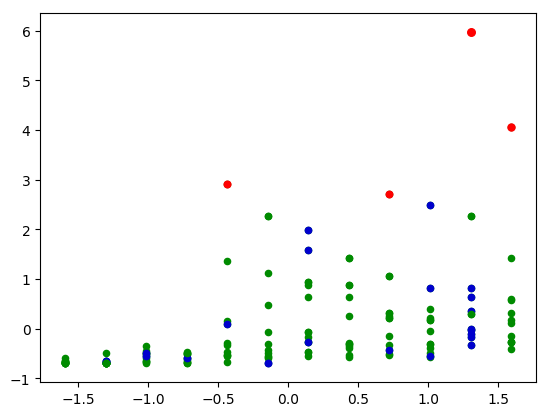

In [15]:
x, y = zip(*Instane2)
plt.scatter(y, x, s=20, color="#008B00")


for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"  #绿色
    plt.scatter(instance[1], instance[0], color=color, s=(value-1)**2*10+20)
plt.show()

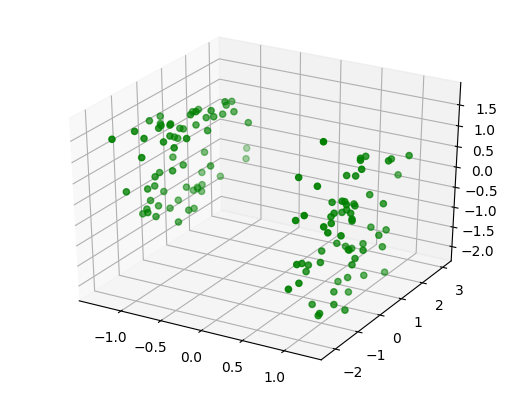

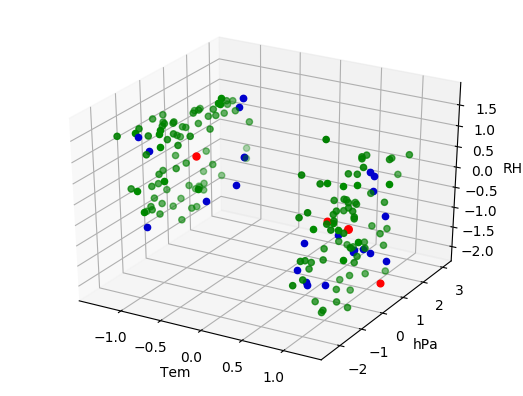

In [16]:
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
plt.show()

ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"
    ax.scatter(instance[4], instance[3], instance[2],  c=color, s=(value-1)**2*10+20)
#     ax.scatter(instance[2], instance[1], instance[0],  c=color, s=(value-1)**2*10+20)
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

sklearn--Anomaly detection with Local Outlier Factor (LOF)
---

In [21]:
# fit the model
# clf = sl.neighbors.LocalOutlierFactor(n_neighbors=20)
# y_pred = clf.fit_predict(Instane5)
# y_pred_outliers = y_pred[10:]

Grubbs异常点检测
---

In [69]:
print(elec_faults2*100)

# =====================================================================================
# Grubbs表，临界值，第一行位为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# GrubbS：计算elec_faults2每列的Grubbs值
# 输入值：Fault：排列好的故障率数据，每个此时地点一组数据，每组长度为12。elec_faults2
# 返回值：
#     Index.append(Max_line[0])              #返回每一组哪个数据的索引值
#     ZSCORE.append(Z_Score)                 #返回具体得分
#     II.append(i)                           #返回第几组索引
#     Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
# =====================================================================================
GrubbsList = [[1.938, 2.097], [2.176, 2.410]] 
LinJieZhi = 0 #0代表0.95；1代表取0.99
def GrubbS(Fault, LinJieZhi=1):
    Index = []
    ZSCORE = []
    II = []
    Value = []
    for i in np.arange(len(Fault.T)):
        Every_line = Fault[:, i]
        Mean_line = Every_line.mean() #计算均值
        Std_line = Every_line.std()   #计算标准差

        Temp = abs(Every_line - Mean_line)
        Max_line = np.where(Temp==np.max(Temp)) #返回最大值的索引
        Max_line = Max_line[0]        #返回索引

        Z_Score = Temp[Max_line[0]]/Std_line
        if len(Every_line)==7:   #确定是哪个省的数据，用于选择GrubbsList的行号
            JJ = 0
        if len(Every_line)==11:
            JJ = 1
            
        if Z_Score > GrubbsList[JJ][LinJieZhi]: #默认取0.95
            Index.append(Max_line[0])              #返回每一组哪个数据的索引值
            ZSCORE.append(Z_Score)                 #返回具体得分
            II.append(i)                           #返回第几组索引
            Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
    return Index, ZSCORE, II, Value

Max_index, Z_score, Hang_index, Max_Value = GrubbS(elec_faults2)
print(Max_index)
print(Hang_index)
print(Z_score)
print(Max_Value)

[[ 0.  0.  4.  3.  3.  3.  6.  5.  8.  6. 10.  6.]
 [ 0.  0.  1.  1.  3.  2.  3.  3.  2.  2.  8.  6.]
 [ 0.  0.  2.  1.  6.  6.  2.  2.  3.  2. 14. 13.]
 [ 1.  1.  5.  4. 30. 26. 23. 19. 25. 22. 22. 18.]
 [ 1.  1.  2.  2.  5.  4.  6.  5.  5.  5. 19. 15.]
 [ 2.  3.  3.  2. 52. 43.  9.  6. 49. 46. 43. 31.]
 [ 0.  0.  0.  0.  1.  0.  8.  6.  4.  3.  5.  4.]
 [ 0.  0.  1.  0.  3.  2. 19. 14. 13. 13. 15. 19.]
 [ 1.  0.  3.  3. 12. 17. 39. 31. 15. 13.  9. 12.]
 [ 0.  0.  3.  3. 11.  9. 33. 23. 13. 10. 96. 69.]
 [ 0.  0.  1.  0.  2.  2. 24. 23. 14. 16. 10.  8.]]
[5, 5, 5, 5, 5, 5, 9, 9]
[0, 1, 4, 5, 8, 9, 10, 11]
[2.544994774935888, 3.025846415214352, 2.6926810640520915, 2.5484898846797073, 2.7297074141559166, 2.7461046979694137, 2.9076660547459365, 2.8809798445643353]
[0.015306903413439462, 0.030613806826878923, 0.5204347160569417, 0.42859329557630493, 0.4898209092300628, 0.45920710240318385, 0.9598244892362539, 0.6855889208830386]
